# Pharma Market Trends


## The Data

**More than 100 pharmaceutical companies measured on a series of profit indicators. Also includes categorical variables, such as the stock recommendation, company location, and stock exchange.**

**Market Cap** = total dollar market value of outstanding shares of stock (in billions).

**Beta** = measure of stock volatility relative to the market, it is effectively a correlation coefficient between the stock and a benchmark (often S&P 500). However, beta can run above 1 if it is consistently swinging more than the market.   

**PE_ratio** = a ratio (Price/per-share-earnings); A high PE_ratio means a stock has a higher price than its value (can occur for various reasons). 13-15 is considered “normal.”

**ROE** = a ratio (net income/shareholder’s equity); It is the ‘Return on Equity’ designed to measure the profits of a corporation compared to the stockholder’s equity. In general, around 15 is acceptable and less than 10 is considered bad. 

**ROA** = a ratio (net income/total assets); It is the ‘Return on Assets’; this is another profitability metric designed to measure how effective a company is using its assets to generating earnings.  

**Asset_Turnover** = a ratio (sales/average assets); The higher the better. It means they are bringing in more revenue with fewer assets.  

**Leverage** = a ratio (debt/equity or assests/equity); Leverage ratio’s can come in many forms. Higher is generally worse.

**Rev_Growth** = change in sales per quarter or year 

**Net_Profit_Margin** = a ratio (net profits/revenue); Illustrates how much revenue translated into profit. 

**Median_Recomendation** = recommendation across analysts (Hold=0, Sell=1)

**Location** = country of origin

**Exchange** = location of exchange

## The Goal 

**We want to understand which variables are important for determining analyst recommendations. We want to then use those predictors to develop a predictive model for projections.** 


### Libraries

In [121]:
#Load Pandas in Python
import pandas as pd
#Load matplotlib
import matplotlib.pyplot as plt
#import numpy
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import statsmodels.api as sm
from factor_analyzer import FactorAnalyzer


### The Data

In [122]:
pharma = pd.read_csv('pharmaMarket3.csv')
pharma.head(10)

,Name,Market_Cap,Beta,PE_Ratio,ROE,ROA,Asset_Turnover,Leverage,Rev_Growth,Net_Profit_Margin,Median_Recommendation,Location,Exchange
0,AZN,67.63,0.52,21.5,27.4,15.4,0.9,0.00,15.00,18.0,Sell,UK,NYSE
1,BAY,16.90,1.11,27.9,3.9,1.4,0.6,0.00,-3.17,2.6,Hold,GERMANY,NYSE
2,BMY,51.33,0.50,13.9,34.8,15.1,0.9,0.57,2.70,20.6,Sell,US,NYSE
3,ELN,0.78,1.08,3.6,15.1,5.1,0.3,1.07,34.21,13.3,Sell,IRELAND,NYSE
4,LLY,73.84,0.18,27.9,31.0,13.5,0.6,0.53,6.21,23.4,Hold,US,NYSE
5,GSK,122.11,0.35,18.0,62.9,20.3,1.0,0.34,21.87,21.1,Hold,UK,NYSE
6,IVX,2.60,0.65,19.9,21.4,6.8,0.6,1.45,13.99,11.0,Hold,US,AMEX
7,MRK,132.56,0.46,18.9,40.6,15.0,1.1,0.28,17.35,14.1,Hold,US,NYSE
8,NVS,96.65,0.19,21.6,17.9,11.2,0.5,0.06,-2.69,22.4,Hold,SWITZERLAND,NYSE
9,PHA,56.24,0.40,56.5,13.5,5.7,0.6,0.35,15.00,7.3,Hold,US,NYSE


### Data Exploration and Visualization

In [123]:
pharma2 = pharma.groupby(['Median_Recommendation']).mean()
pharma2.reset_index(inplace=True)
pharma2

,Median_Recommendation,Market_Cap,Beta,PE_Ratio,ROE,ROA,Asset_Turnover,Leverage,Rev_Growth,Net_Profit_Margin
0,Hold,66.198889,1.272778,25.519444,30.630556,11.952778,1.486111,1.233889,9.383889,16.886111
1,Sell,32.118750,1.335000,15.156250,22.837500,11.437500,1.403125,1.205000,21.141250,17.650000


**Percentages of Recomendations** 

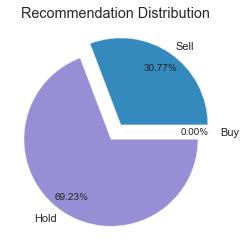

In [126]:
plt.style.use('ggplot') # add theme template
buy  = pharma.loc[pharma['Median_Recommendation']=='Buy'].count()[0] #create vectors for plot with counts
sell = pharma.loc[pharma['Median_Recommendation']=='Sell'].count()[0]
hold = pharma.loc[pharma['Median_Recommendation']=='Hold'].count()[0]

recs = [buy, sell, hold]
labels  = ['Buy','Sell','Hold']
explode = [.1,.1,.1]
plt.title('Recommendation Distribution')
plt.pie(recs, labels=labels, autopct='%.2f%%', pctdistance=0.8, explode=explode)

plt.show()

Analyst tend to recommend holding stocks more than selling (69.2% vs. 30.8%). 

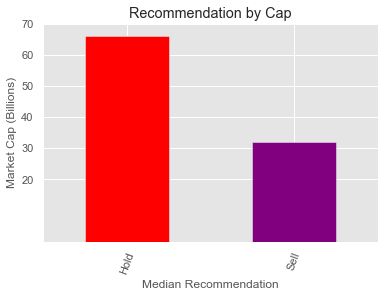

In [125]:
plt.style.use('ggplot')
pharma2.plot.bar(x="Median_Recommendation", y="Market_Cap", rot=70, color=['red', 'purple'] , title="Recommendation by Cap");
plt.yticks([20,30,40,50,60,70])
plt.ylabel('Market Cap (Billions)')
plt.xlabel('Median Recommendation')
plt.legend().remove()
plt.show()

Higher market caps seem to result in hold recommendations for stocks.  

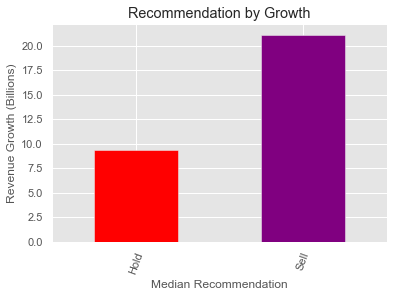

In [127]:
plt.style.use('ggplot')
pharma2.plot.bar(x="Median_Recommendation", y="Rev_Growth", rot=70, color=['red', 'purple'] , title="Recommendation by Growth");
plt.ylabel('Revenue Growth (Billions)')
plt.xlabel('Median Recommendation')
plt.legend().remove()
plt.show()

Higher revenue growth results in sell recommendations. 

In [128]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

### Clean data for Logistic Regression

In [144]:
##Keep only variables of interest
data_final = pd.read_csv('pharmaMarket3.csv') # import
data_final = data_final.iloc[0:110,0:11] #remove location, stock exchange
data_final.loc[data_final['Median_Recommendation']=='Sell', 'Median_Recommendation']='1' #change for coding scheme
data_final.loc[data_final['Median_Recommendation']=='Hold', 'Median_Recommendation']='0' #change for coding scheme
data_final["Median_Recommendation"] = data_final["Median_Recommendation"].astype(str).astype(int) #make new coding variable an int64
data_final

#data_final.dtypes

,Name,Market_Cap,Beta,PE_Ratio,ROE,ROA,Asset_Turnover,Leverage,Rev_Growth,Net_Profit_Margin,Median_Recommendation
0,AZN,67.63,0.52,21.5,27.4,15.4,0.9,0.00,15.00,18.0,1
1,BAY,16.90,1.11,27.9,3.9,1.4,0.6,0.00,-3.17,2.6,0
2,BMY,51.33,0.50,13.9,34.8,15.1,0.9,0.57,2.70,20.6,1
3,ELN,0.78,1.08,3.6,15.1,5.1,0.3,1.07,34.21,13.3,1
4,LLY,73.84,0.18,27.9,31.0,13.5,0.6,0.53,6.21,23.4,0
...,...,...,...,...,...,...,...,...,...,...,...
99,ISY,102.65,6.19,27.6,23.9,17.2,6.5,6.06,3.31,28.4,0
100,UHZ,62.24,6.40,62.5,19.5,11.7,6.6,6.35,21.00,13.3,0
101,ZHV,40.10,6.51,24.9,28.6,19.3,6.8,6.00,14.56,23.6,0
102,XBO,9.26,6.24,24.4,16.2,12.8,6.5,6.20,35.18,21.1,1


### Run Logistic Regression

In [145]:
Xtrain = data_final[['Market_Cap','Beta','ROE', 'ROA', 'Asset_Turnover','Leverage','Rev_Growth', 'Net_Profit_Margin']] # no PE_Ratio
ytrain = data_final[['Median_Recommendation']]


import statsmodels.api as sm
log_reg = sm.Logit(ytrain, Xtrain).fit()
print(log_reg.summary())

#This model is second attempt:
##PE_Ratio is removed after leave-one-out approach, model was singular with it included  

Optimization terminated successfully.
         Current function value: 0.381412
         Iterations 8
                             Logit Regression Results                            
Dep. Variable:     Median_Recommendation   No. Observations:                  104
Model:                             Logit   Df Residuals:                       96
Method:                              MLE   Df Model:                            7
Date:                   Thu, 20 May 2021   Pseudo R-squ.:                  0.3821
Time:                           13:14:26   Log-Likelihood:                -39.667
converged:                          True   LL-Null:                       -64.193
Covariance Type:               nonrobust   LLR p-value:                 2.216e-08
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Market_Cap           -0.0471      0.017     -2.769      0.006      -0.

Model fit isn't bad for size of dataset, but only 'Market Cap' is significant predictor. Run a factor analysis to explore.  

### Explore Correlated Variables

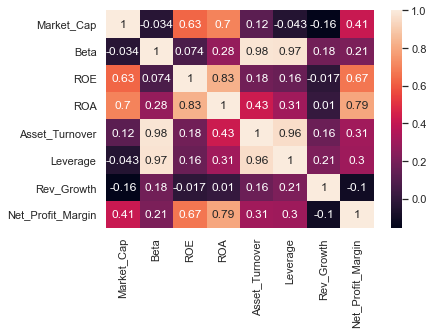

In [134]:
# Check for correlations 
data_corr = Xtrain.iloc[0:110,0:10] #specify which to variabls to include 
sns.heatmap(data_corr.corr(),annot=True) #add correlation coefficient to plot
plt.show()

There are high correlations between some variables (e.g., Beta, Leverage, Asset Turnover)

## Factor Analysis

In [59]:
#Barlett's Test of Sphericity: evaluates whether or not the observed variables intercorrelate. 
#Significant p-value means factor analysis is appropriate 
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(Xtrain)
chi_square_value, p_value



(1202.1502233936399, 9.708657136477492e-236)

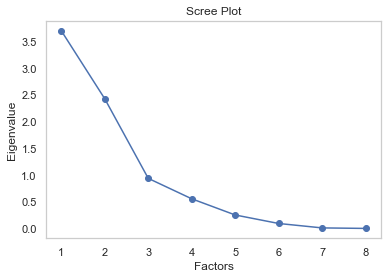

In [60]:
# Create factor analysis object to run factor analysis
fa = FactorAnalyzer()
fa.fit(Xtrain)
ev, v = fa.get_eigenvalues()
ev

#plot Eigen by Factor
plt.scatter(range(1,Xtrain.shape[1]+1),ev)
plt.plot(range(1,Xtrain.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

2-3 factors are ideal. We want eigen values >1

In [136]:
#Determine factor loadings
fa = FactorAnalyzer(3, rotation="varimax") #use varimax rotation
fa.fit(Xtrain) 
loadings = fa.loadings_

#plot factors
loadingsdf = pd.DataFrame(data=loadings, index=['Market_Cap','Beta','ROE', 'ROA', 'Asset_Turnover','Leverage','Rev_Growth', 'Net_Profit_Margin'], columns=['Factor1', 'Factor2','Factor2' ])
loadingsdf

,Factor1,Factor2,Factor2
Market_Cap,-0.089635,0.481350,0.871589
Beta,0.992937,0.093734,0.011997
ROE,-0.000136,0.806216,0.264691
ROA,0.184754,0.916314,0.317826
Asset_Turnover,0.965289,0.210604,0.118589
Leverage,0.960140,0.199554,-0.069745
Rev_Growth,0.200372,-0.045748,-0.104788
Net_Profit_Margin,0.130627,0.821950,0.044824


**Factor 1:** Beta, Asset_Turnover, Leverage

**Factor 2:** ROE, ROA, Net_Profit_Margin

**Factor 3:** Market_Cap

Opting for two factor loading (i.e., Factor 3 only loaded on Market Cap) 

In [137]:
# Get variance of each factors
fa.get_factor_variance()
variances = fa.get_factor_variance()

#Plot factor variance
variancesdf = pd.DataFrame(data=variances, index=['Loadings','Prop Var','Cum Var'], columns=['1', '2', '3' ])
variancesdf

,1,2,3
Loadings,2.938957,2.491971,0.962803
Prop Var,0.367370,0.311496,0.120350
Cum Var,0.367370,0.678866,0.799216


**79.9% of variance explained by factors**

### Run Logistic Regression with Factors loadings 

In [146]:
#Make new df
Xtrain2 = Xtrain
#First combine variables into two latent factors
Xtrain2["Risk"] = (Xtrain2['Beta']+Xtrain2['Leverage']+Xtrain2['Asset_Turnover'])
Xtrain3 = Xtrain2.drop(columns=['Beta', 'Leverage','Asset_Turnover'])
Xtrain3
##This model is second attempt: First attempt did not improve model fit with inclusion of two Factors. 
##This model includes only Factor 1

<ipython-input-146-30c41e372046>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtrain2["Risk"] = (Xtrain2['Beta']+Xtrain2['Leverage']+Xtrain2['Asset_Turnover'])


,Market_Cap,ROE,ROA,Rev_Growth,Net_Profit_Margin,Risk
0,67.63,27.4,15.4,15.00,18.0,1.42
1,16.90,3.9,1.4,-3.17,2.6,1.71
2,51.33,34.8,15.1,2.70,20.6,1.97
3,0.78,15.1,5.1,34.21,13.3,2.45
4,73.84,31.0,13.5,6.21,23.4,1.31
...,...,...,...,...,...,...
99,102.65,23.9,17.2,3.31,28.4,18.75
100,62.24,19.5,11.7,21.00,13.3,19.35
101,40.10,28.6,19.3,14.56,23.6,19.31
102,9.26,16.2,12.8,35.18,21.1,18.94


In [147]:
import statsmodels.api as sm
log_reg = sm.Logit(ytrain, Xtrain3).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.381821
         Iterations 7
                             Logit Regression Results                            
Dep. Variable:     Median_Recommendation   No. Observations:                  104
Model:                             Logit   Df Residuals:                       98
Method:                              MLE   Df Model:                            5
Date:                   Thu, 20 May 2021   Pseudo R-squ.:                  0.3814
Time:                           13:14:37   Log-Likelihood:                -39.709
converged:                          True   LL-Null:                       -64.193
Covariance Type:               nonrobust   LLR p-value:                 2.253e-09
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Market_Cap           -0.0472      0.013     -3.521      0.000      -0.

With Factor 1 included, we now have 5 significant 
or near-significant predictors (to be evaluated as dataset grows).

Factor 1 has also been renamed "Risk", as variables included in factor relate to volatility and fund management. 

### Evaluate Model 

In [106]:
#Split data as arrays
X_var = np.asarray(Xtrain3[['Market_Cap','ROE', 'ROA', 'Rev_Growth', 'Factor1']]) # dropped Net Prof Marg
y_var = np.asarray(ytrain['Median_Recommendation'])

from termcolor import colored as cl # text customization
print(cl('X_var samples : ', attrs = ['bold']), X_var[:5])
print(cl('y_var samples : ', attrs = ['bold']), y_var[:5])

X_var samples :  [[67.63 27.4  15.4  15.    1.42]
 [16.9   3.9   1.4  -3.17  1.71]
 [51.33 34.8  15.1   2.7   1.97]
 [ 0.78 15.1   5.1  34.21  2.45]
 [73.84 31.   13.5   6.21  1.31]]
y_var samples :  [1 0 1 1 0]


In [107]:
#Create Test and Training sets 
X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, test_size = 0.4, random_state = 4)

print(cl('X_train samples : ', attrs = ['bold']), X_train[:5])
print(cl('X_test samples : ', attrs = ['bold']), X_test[:5])
print(cl('y_train samples : ', attrs = ['bold']), y_train[:10])
print(cl('y_test samples : ', attrs = ['bold']), y_test[:10])

X_train samples :  [[ 2.6  21.4   6.8  13.99  2.7 ]
 [72.63 34.4  18.4  19.    1.96]
 [ 3.26 10.2   6.8  29.18  0.94]
 [ 3.76 10.7   7.3  29.68  2.44]
 [56.34 13.6   5.8  15.1   1.65]]
X_test samples :  [[ 56.04  13.3    5.5   14.8    0.75]
 [122.11  62.9   20.3   21.87   1.69]
 [ 62.24  19.5   11.7   21.    19.35]
 [132.66  40.7   15.1   17.45   2.14]
 [ 56.33  34.8   15.1    2.7    1.97]]
y_train samples :  [0 1 1 1 0 0 0 0 1 0]
y_test samples :  [0 0 0 0 1 0 1 0 0 1]


In [108]:
lr = LogisticRegression(C = 0.1, solver = 'liblinear')
lr.fit(X_train,y_train)

print(cl(lr, attrs = ['bold']))

LogisticRegression(C=0.1, solver='liblinear')


In [109]:
#Make predictions
yhat = lr.predict(X_test)
yhat_prob = lr.predict_proba(X_test)

print(cl('yhat samples : ', attrs = ['bold']), yhat[:10])
print(cl('yhat_prob samples : ', attrs = ['bold']), yhat_prob[:10])

yhat samples :  [0 0 0 0 0 1 0 0 0 1]
yhat_prob samples :  [[0.77201908 0.22798092]
 [0.98694815 0.01305185]
 [0.71126358 0.28873642]
 [0.98238975 0.01761025]
 [0.81878394 0.18121606]
 [0.36948228 0.63051772]
 [0.53999659 0.46000341]
 [0.98878985 0.01121015]
 [0.50900696 0.49099304]
 [0.19258206 0.80741794]]


### Evaluate Model Predictions

In [110]:
#Overall Model evaluation via Log loss
from sklearn.metrics import precision_score # evaluation metric
print(cl('Precision Score of our model is {}'.format(precision_score(y_test, yhat).round(2)), attrs = ['bold']))


Precision Score of our model is 0.7


In [113]:
y_pred = lr.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.74


[[24  3]
 [ 8  7]]


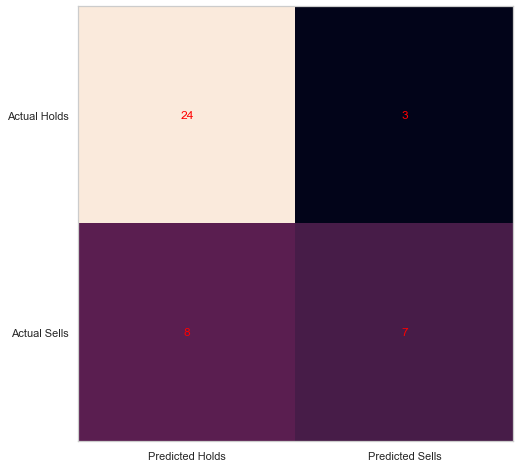

In [148]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(confusion_matrix)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Holds', 'Predicted Sells'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Holds', 'Actual Sells'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='red')
plt.show()

Model fairly accurate given amount of data: 31 correct (24 Hold, 7 Sell) and 11 (3 hold, 8 sell) incorrect interpretations. 

**True Positive:** 24
**True Negative:** 7
**False Positive:** 3
**False Negative:**  8


In [150]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.89      0.81        27
           1       0.70      0.47      0.56        15

    accuracy                           0.74        42
   macro avg       0.72      0.68      0.69        42
weighted avg       0.73      0.74      0.72        42



**Precision:** ratio tp / (tp + fp); 
ability of the classifier to not label a sample as positive if it is negative 

**Recall:** ratio tp / (tp + fn);
ability of the classifier to find all the positive samples

**F-1 Score:** weighted (for recall) mean of precision and recall (0-1)

**Support:** # of occurances per class

We see the model is better at predicting 'holds' than 'sells'. This is expected provided 2x frequency of 'hold' recommendations. Accuracy for 'holds' was above 80% accuracy, which suggests the model inputs are quality metrics (the logistic regression also suggests this). More input is needed to improve the model accuracy for 'sells,' which is around chance accuracy (50%).   


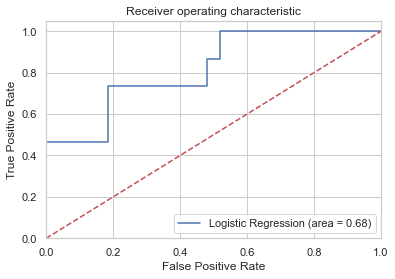

In [151]:
#ROC Curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

##Far from dotted line is good